In [ ]:
# Installa le librerie necessarie
!pip install transformers torch

# Effettua il login su Hugging Face (assicurati di inserire il token quando richiesto)
from huggingface_hub import notebook_login
notebook_login()

# Importa il modello e il tokenizer dal repository affinato su Hugging Face
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import json
import pandas as pd


# Carica il modello e il tokenizer dal repository
model_name = "Teto03/Bert_base_fineTuned"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

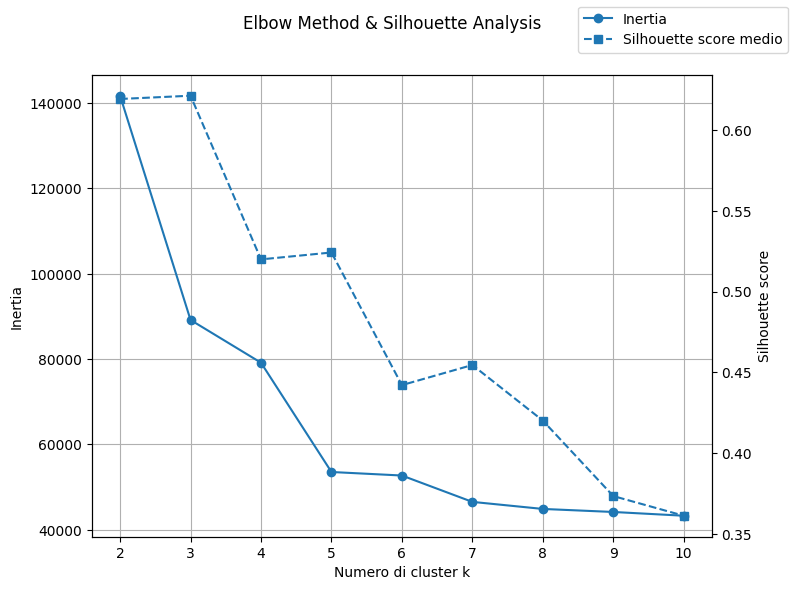

Numero ottimale di cluster by silhouette: 3


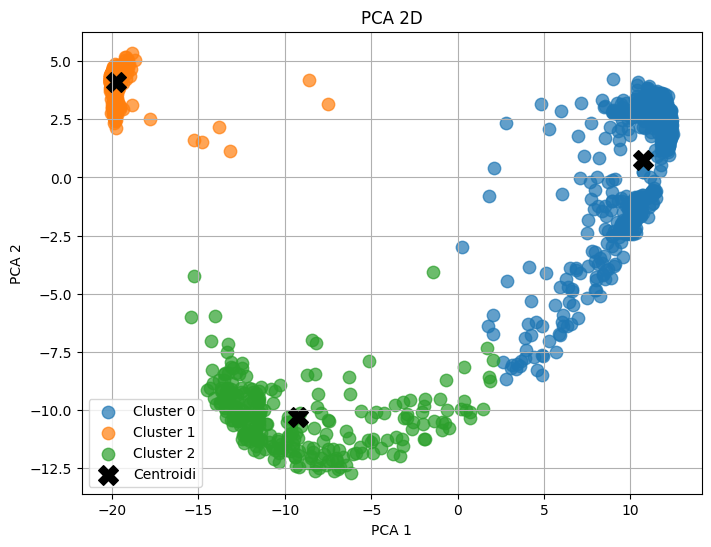

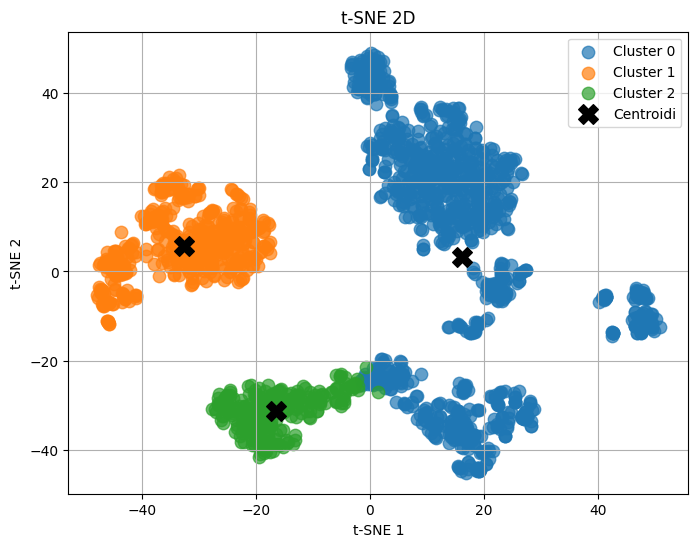

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


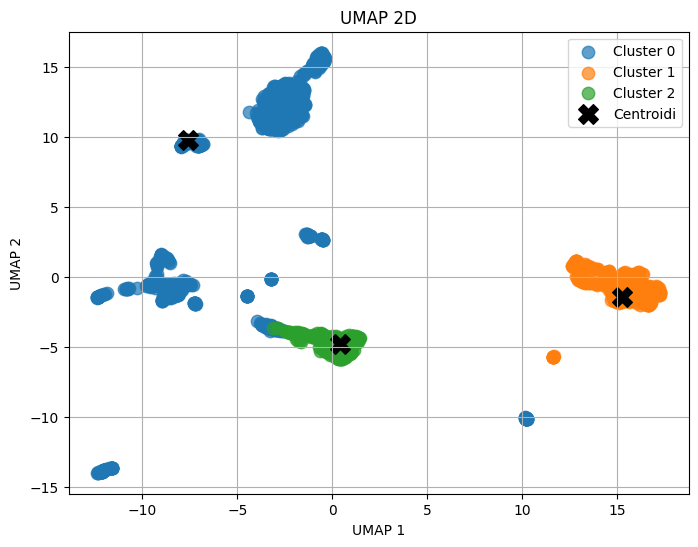

Average silhouette score (k=3): 0.6212


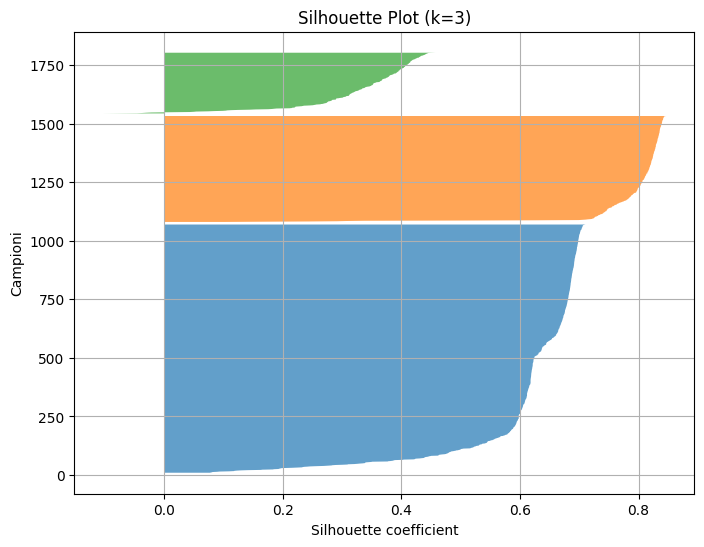


Distribuzione dei cluster:
  Cluster 0: 1060 elementi (59.79%)
  Cluster 1: 453 elementi (25.55%)
  Cluster 2: 260 elementi (14.66%)


In [ ]:
# -*- coding: utf-8 -*-
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples
import umap

# ======================================================================
# BLOCCO 0: Caricamento embedding (invariato)
# ======================================================================
with open("response.json", "r") as f:
    responses = json.load(f)

embedding_list = []
for item in responses:
    text = item.get("response", "")
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs, output_hidden_states=True)
    emb = outputs.hidden_states[-1][:, 0, :].squeeze(0).detach().cpu().numpy()
    embedding_list.append(emb)

X = np.array(embedding_list)

# ======================================================================
# BLOCCO 1: Ricerca del numero ottimale di cluster (Elbow + Silhouette)
# ======================================================================
ks = range(2, 11)
inertias = []
sil_scores = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42).fit(X)
    labels = km.labels_
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X, labels))

# Plot Elbow & Silhouette
fig, ax1 = plt.subplots(figsize=(8,6))
ax1.plot(ks, inertias, 'o-', label='Inertia')
ax1.set_xlabel('Numero di cluster k')
ax1.set_ylabel('Inertia')
ax2 = ax1.twinx()
ax2.plot(ks, sil_scores, 's--', label='Silhouette score medio')
ax2.set_ylabel('Silhouette score')
fig.suptitle("Elbow Method & Silhouette Analysis")
ax1.grid(True)
fig.legend(loc='upper right')
plt.savefig("elbow_silhouette.png")
plt.show()

# Selezione del k che massimizza la silhouette media
best_k = ks[np.argmax(sil_scores)]
print(f"Numero ottimale di cluster by silhouette: {best_k}")

# ======================================================================
# BLOCCO 2: Clustering finale con k = best_k
# ======================================================================
kmeans = KMeans(n_clusters=best_k, random_state=42).fit(X)
clusters = kmeans.labels_

# ======================================================================
# BLOCCO 3: Visualizzazioni 2D per il clustering finale
# ======================================================================
# Funzione helper per i tre tipi di embedding 2D
def plot_2d(emb2d, title, filename):
    plt.figure(figsize=(8,6))
    for i in range(best_k):
        pts = emb2d[clusters == i]
        plt.scatter(pts[:,0], pts[:,1], label=f"Cluster {i}", s=80, alpha=0.7)
    # Centroidi
    if title == "PCA 2D":
        centroids2d = pca.transform(kmeans.cluster_centers_)
    elif title == "t-SNE 2D":
        centroids2d = np.array([emb2d[clusters==i].mean(axis=0) for i in range(best_k)])
    else:  # UMAP
        centroids2d = reducer.transform(kmeans.cluster_centers_)
    plt.scatter(centroids2d[:,0], centroids2d[:,1], marker='X', s=200, c='black', label='Centroidi')
    plt.title(title)
    plt.xlabel(f"{title.split()[0]} 1")
    plt.ylabel(f"{title.split()[0]} 2")
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

# PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)
plot_2d(X_pca, "PCA 2D", "clustering_pca.png")

# t-SNE
perp = min(30, X.shape[0]-1)
X_tsne = TSNE(n_components=2, perplexity=perp, random_state=42).fit_transform(X)
plot_2d(X_tsne, "t-SNE 2D", "clustering_tsne.png")

# UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X)
plot_2d(X_umap, "UMAP 2D", "clustering_umap.png")

# ======================================================================
# BLOCCO 4: Analisi delle metriche del clustering finale
# ======================================================================
# Silhouette score medio
avg_sil = silhouette_score(X, clusters)
print(f"Average silhouette score (k={best_k}): {avg_sil:.4f}")

# Silhouette plot dettagliato
sil_vals = silhouette_samples(X, clusters)
plt.figure(figsize=(8,6))
y_lower = 10
for i in range(best_k):
    ith_vals = sil_vals[clusters == i]
    ith_vals.sort()
    size = ith_vals.shape[0]
    y_upper = y_lower + size
    y_range = np.arange(y_lower, y_upper)
    plt.fill_betweenx(y_range, 0, ith_vals, alpha=0.7)
    y_lower = y_upper + 10

plt.title(f"Silhouette Plot (k={best_k})")
plt.xlabel("Silhouette coefficient")
plt.ylabel("Campioni")
plt.grid(True)
plt.savefig("silhouette_plot.png")
plt.show()

# Distribuzione dei cluster
counts = np.bincount(clusters)
print("\nDistribuzione dei cluster:")
for i, cnt in enumerate(counts):
    pct = cnt / len(clusters) * 100
    print(f"  Cluster {i}: {cnt} elementi ({pct:.2f}%)")

